In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

%matplotlib inline
from keras.utils import np_utils

train_df = pd.read_csv('rotten/train.tsv', sep='\t', header=0)
test_df = pd.read_csv('rotten/test.tsv', sep='\t', header=0)
train_df.head(2)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


In [50]:
# compute intersection of dictionaries
phrases = train_df["Phrase"].values
toke = Tokenizer()
toke.fit_on_texts(phrases)
word_index = toke.word_index.keys()

phrases = test_df["Phrase"].values
toke = Tokenizer()
toke.fit_on_texts(phrases)
word_index2 = toke.word_index.keys()

a = word_index2 & word_index
print("intersection size %i" %len(a))
print("training corpus size %i" %len(word_index))
print("test corpus size %i" %len(word_index2))

intersection length 7096
training corpus size 15288
test corpus size 9588


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 100


phrases = train_df["Phrase"].values
toke = Tokenizer()
toke.fit_on_texts(phrases)
sequences = toke.texts_to_sequences(phrases)
word_index = toke.word_index
print('Found %s unique tokens.' % len(word_index))
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_train = np_utils.to_categorical(train_df["Sentiment"].values)
X_test = pad_sequences(toke.texts_to_sequences(test_df["Phrase"].values), maxlen=MAX_SEQUENCE_LENGTH)

#load glove vectors
embeddings_index = {}
GLOVE_DIR = 'rotten/glove.6B'
import os
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%id.txt' %EMBEDDING_DIM))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
#take only word vecs that are in training dictionary
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 15288 unique tokens.
Found 400000 word vectors.


(array([  1.59900000e+04,   2.67400000e+04,   2.15490000e+04,
          1.50330000e+04,   2.03910000e+04,   7.36200000e+03,
          6.20900000e+03,   5.31200000e+03,   8.54000000e+03,
          3.54800000e+03,   3.02900000e+03,   2.69600000e+03,
          2.45500000e+03,   4.14100000e+03,   1.76200000e+03,
          1.49000000e+03,   1.32100000e+03,   2.36600000e+03,
          8.82000000e+02,   7.86000000e+02,   6.74000000e+02,
          6.15000000e+02,   9.83000000e+02,   3.67000000e+02,
          3.16000000e+02,   3.20000000e+02,   4.34000000e+02,
          1.33000000e+02,   1.24000000e+02,   1.08000000e+02,
          9.20000000e+01,   1.11000000e+02,   4.50000000e+01,
          3.90000000e+01,   3.00000000e+01,   2.80000000e+01,
          1.40000000e+01,   1.20000000e+01,   1.00000000e+01,
          3.00000000e+00]),
 array([  0.   ,   1.225,   2.45 ,   3.675,   4.9  ,   6.125,   7.35 ,
          8.575,   9.8  ,  11.025,  12.25 ,  13.475,  14.7  ,  15.925,
         17.15 ,  18.375

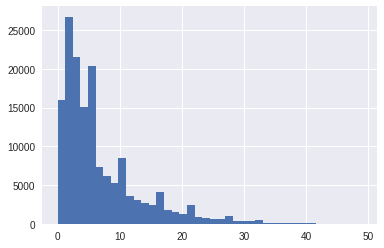

In [5]:
lengths = np.asarray([len(s) for s in sequences])
plt.hist(lengths,40)

In [6]:
#LSTM with embedding trainable
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Embedding, BatchNormalization
from keras.layers import LSTM, GRU, AveragePooling1D

opt = Adam(0.004)
inp = Input(shape=X_train.shape[1:])
x = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True,
              input_shape=X_train.shape[1:])(inp)
x = LSTM(256, return_sequences=False, dropout_W = 0.3, dropout_U = 0.3)(x)
#x = BatchNormalization()(x)
pred = Dense(5,activation='softmax')(x)

model = Model(inp,pred)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 20)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 20, 100)       1528900     input_1[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 256)           365568      embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 5)             1285        lstm_1[0][0]                     
Total params: 1,895,753
Trainable params: 1,895,753
Non-trainable params: 0
_______________

In [7]:
#kaggle results: 
# 0.65589, glove embeddings only for words E training corpus, but trainable, 3 epochs only
# x = LSTM(256, return_sequences=False, dropout_W = 0.3, dropout_U = 0.3)(x)
# x = BatchNormalization()(x) + Dense 5

# 0.65234 no batchnorm, plus validation split


idx = np.random.permutation(X_train.shape[0])
model.fit(X_train[idx], y_train[idx], nb_epoch=3, batch_size=128, verbose=1,validation_split=0.2)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 41s - loss: 0.9007 - categorical_accuracy: 0.6262 - val_loss: 0.8012 - val_categorical_accuracy: 0.6683
Epoch 2/3
124848/124848 [==============================] - 39s - loss: 0.7459 - categorical_accuracy: 0.6875 - val_loss: 0.7810 - val_categorical_accuracy: 0.6777
Epoch 3/3
124848/124848 [==============================] - 39s - loss: 0.6751 - categorical_accuracy: 0.7152 - val_loss: 0.7908 - val_categorical_accuracy: 0.6755


In [8]:
predictions = model.predict(X_test,batch_size=256)
preds = np.argmax(predictions,axis=1)
test_df["Sentiment"] = pd.Series(preds,index=test_df.index)
header = ["PhraseId", "Sentiment"]
test_df.to_csv('rotten/predictions.csv', columns = header,index=False)